## Fittin BSpline network with monotonicity constraints 

In [1]:
import sys
import matplotlib as m

sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from absl import app
from absl import flags

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from dcc import AAV, Parameters
import numpy as np
import matplotlib.pyplot as plt

import patsy
from scipy.interpolate import BSpline

from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In this exercise, we adapt the SGD learning algorithm for a feed-forward neural network when monotonicity is required in the input-output mapping. We start with a toy 1-D regression problem with target data generated by the function
$$ y = x^3 - 5x \exp(-100 x^2) + U[-0.05, 0.05] $$

That is an increasing unidimensional function pertrubed by a simple wavelet

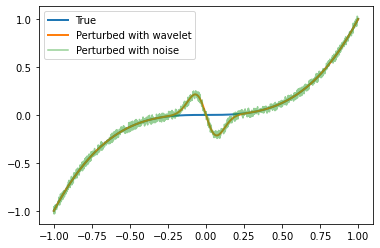

In [2]:
n_points = 1000
x_low = -1
x_high = 1
x = np.linspace(-1, 1, n_points, dtype='float32')
y_true = np.power(x, 3)
y_wave = np.power(x, 3) - 5 * x * np.exp(-100 * np.square(x))
y_perturbed = y_wave + np.random.uniform(-0.05, 0.05, n_points)
fig, ax = plt.subplots()
ax.plot(x, y_true, linewidth=2.0)
ax.plot(x, y_wave, linewidth=2.0)
ax.plot(x, y_perturbed, alpha=0.5)
ax.legend(['True', 'Perturbed with wavelet', 'Perturbed with noise'])

We will approximated the Perturbed wavelet function with basis splines of order three. The architecture is idnetical to a shallow neural network -- that is first applying transform on the single dimensional input to get Basis "features" and then optimize with SGD

Text(0.5, 1.0, 'In SciPy')

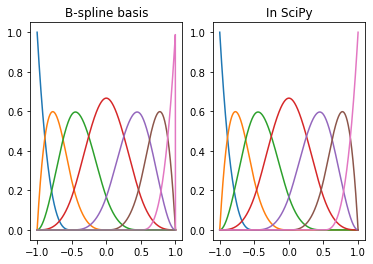

In [3]:
import patsy # for comparison

these_knots = np.linspace(x_low, x_high, 5)

# PATSY R implementation
p = 3
# in Patsy/R: nice and sensible
y_patsy = patsy.bs(x, knots=these_knots, degree=p)
plt.subplot(1,2,1)
plt.plot(x, y_patsy)
plt.title('B-spline basis')

# Scipy implemntation
numpyknots = np.concatenate(([x_low] * p ,these_knots, [x_high] * p)) # because??
y_py = np.zeros((x.shape[0], len(these_knots)+ p - 1))
for i in range(len(these_knots) + p - 1):
    y_py[:,i] = BSpline(numpyknots, (np.arange(len(these_knots)+ p - 1)==i).astype(float), p, extrapolate=False)(x)

plt.subplot(1,2,2)
plt.plot(x,y_py)
plt.title('In SciPy')

In [4]:
y_py.shape

(1000, 7)

Sum of all the basis elements evaluated in a sinble point $t \in [x_\min, x_\max]$ is 1

Sum of all the basis elements: 1.0


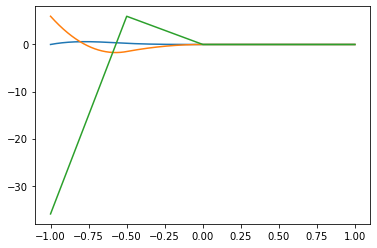

In [5]:
print(f"Sum of all the basis elements: {np.array([BSpline(numpyknots, (np.arange(len(these_knots)+p-1)==i).astype(float), p, extrapolate=False)((x_high-x_low)/2) for i in range(len(these_knots)+p-1)]).sum()}")
plt.plot(x, BSpline(numpyknots, (np.arange(len(these_knots)+p-1)==1).astype(float), p, extrapolate=False)(x))
if p>1:
    plt.plot(x, BSpline(numpyknots, (np.arange(len(these_knots)+p-1)==1).astype(float), p, extrapolate=False).derivative()(x))
if p>2:
    plt.plot(x, BSpline(numpyknots, (np.arange(len(these_knots)+p-1)==1).astype(float), p, extrapolate=False).derivative().derivative()(x))

Here are functions that define input transformations to BSplines as well as their derivatives for the monotonicity constraint.

In [6]:
these_knots = np.linspace(x_low, x_high, 10)
def transform_1d(eval_point, p=3, these_knots=these_knots):
    numpyknots = np.concatenate(([x_low]*p, these_knots, [x_high]*p)) 
    y_py = np.zeros((eval_point.shape[0], len(these_knots) + p - 1 + 1))
    y_py[:, 0] = eval_point
    for i in range(len(these_knots)+p-1):
        y_py[:,i+1] = BSpline(numpyknots, (np.arange(len(these_knots)+p-1)==i).astype(float), p, extrapolate=False)(eval_point)
    y_py = np.float32(y_py)
    return y_py

def transform_1d_der(eval_point, these_knots=these_knots, p=3):
    numpyknots = np.concatenate(([x_low]*p, these_knots, [x_high]*p)) 
    y_py = np.zeros((eval_point.shape[0], len(these_knots)+p-1) )
    #y_py[:, 0] = eval_point
    for i in range(len(these_knots)+p-1):
        y_py[:,i] = BSpline(numpyknots, (np.arange(len(these_knots)+p-1)==i).astype(float), p, extrapolate=False).derivative()(eval_point)
    y_py = np.float32(y_py)
    return y_py

In [7]:
transform_1d(np.array([0.]))

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.02083333, 0.47916666, 0.47916666, 0.02083333, 0.        ,
        0.        , 0.        , 0.        ]], dtype=float32)

### Training fith tf.model.fit

In [8]:
p = 3
features = len(these_knots) + p - 1 + 1
inputs = tf.keras.Input(shape=(features,))
first_layer = tf.keras.layers.Dense(1, activation='linear', use_bias=False)(inputs[:, 1:])
model = tf.keras.Model(inputs=inputs, outputs=first_layer, name="combined")
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[WARNING] [2021-07-04 18:31:45,273] [tensorflow] - AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000026066A64828> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has n

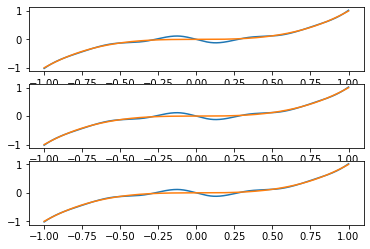

In [9]:
bs = 30
epochs = 200
model.fit(transform_1d(x, p), y_perturbed, epochs=epochs, verbose=False, batch_size=bs, shuffle=True)
fig, ax = plt.subplots(nrows = 3)
y_pred = model.predict_on_batch(transform_1d(x, p)).flatten()
ax[0].plot(x, y_pred)
ax[0].plot(x, y_true)
model.fit(transform_1d(x, p), y_perturbed, epochs=epochs, verbose=False, batch_size=bs, shuffle=True)
y_pred = model.predict_on_batch(transform_1d(x, p)).flatten()
ax[1].plot(x, y_pred)
ax[1].plot(x, y_true)
model.fit(transform_1d(x, p), y_perturbed, epochs=epochs, verbose=False, batch_size=bs, shuffle=True)
y_pred = model.predict_on_batch(transform_1d(x, p)).flatten()
ax[2].plot(x, y_pred)
ax[2].plot(x, y_true)

### Fitting with gradient tape
In this section we write a custom training loop with tf.gradient.tape and check it against tf.model.fit. Model fit incorporates shuffling of the training samples before separation into batches, so we try to mimic this with the shuffle function from tf.data.Datasets

In [10]:
transform_1d_der([(i, j) for i,j in tf.data.Dataset.from_tensor_slices((transform_1d(x), y_true)).batch(32)][0][0][:, 0].numpy()).shape

(32, 12)

In [11]:
def train_step(trainable_model, dset, penalization=None, epoch=0):  
    batch_loss = np.zeros(len(dset))
    batch_penal = np.zeros(len(dset))
    for i, (x_batch, y_batch) in enumerate(dset):
        with tf.GradientTape() as tape:
            batch_penal[i] = penalization(trainable_model.weights[0].numpy(), x_batch[:,0].numpy(), epoch)
            predictions = trainable_model(x_batch, training=True)
            loss_value = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_batch, predictions)) + batch_penal[i]
#             print(loss_value)
#             print(predictions)
#             print(x_batch)
#             print(y_batch)
            batch_loss[i] = loss_value.numpy()
        gradients = tape.gradient(loss_value, trainable_model.trainable_variables)
        trainable_model.optimizer.apply_gradients(zip(gradients, trainable_model.trainable_variables))
    return np.mean(batch_loss), np.mean(batch_penal)


def fit_model(trainable_model, X, y, epochs, penal=None, batch=32, verbose=False, shuffle=False):
    losses = np.zeros(epochs)
    penalizations = np.zeros(epochs)
    y = y[:, None]
    if shuffle:
        #x, y = unison_shuffled_copies(x, y)
        dset = tf.data.Dataset.from_tensor_slices((X,y)).shuffle(len(y)).batch(batch)
    else:
        dset = tf.data.Dataset.from_tensor_slices((X,y)).batch(batch)
    if penal is None:
        penal = lambda modeli, xi, ii: 0.0
    for i, epoch in enumerate(range(0, epochs)):
        losses[i], penalizations[i] = train_step(trainable_model, dset=dset, penalization=penal, epoch=i)
        if verbose:
            print(f'Epoch:{i}/{epochs} Loss: {losses[i]}')
    return losses, penalizations

def unison_shuffled_copies(a, b):
    # shuffles the two arrays such that they preserve their feature order
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p, :], b[p]


class Penal:
    def __init__(self):
        pass
    
    def calc_penal(self):
        pass

First lets, test whether the model.fit method corresponds to our implementation of the gradient tape. For that we set-up two identical models with same weight initialization.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[WARNING] [2021-07-04 18:31:54,966] [tensorflow] - AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x00000260672F4EE8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has n

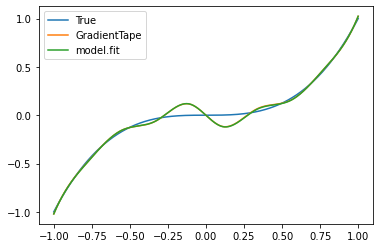

In [12]:
p = 3
features = len(these_knots) + p - 1 + 1

inputs = tf.keras.Input(shape=(features,))
first_layer = tf.keras.layers.Dense(1, activation='linear', use_bias=False)(inputs[:, 1:])
model = tf.keras.Model(inputs=inputs, outputs=first_layer, name="combined")
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')

inputs_cp = tf.keras.Input(shape=(features,))
first_layer_cp = tf.keras.layers.Dense(1, activation='linear', use_bias=False)(inputs_cp[:, 1:])
modelcp = tf.keras.Model(inputs=inputs_cp, outputs=first_layer_cp, name="custom")
modelcp.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')

starting_weights = model.get_weights().copy()

def reset_weights(resetting_model):
    resetting_model.set_weights(starting_weights)

reset_weights(modelcp)

bs = 30
n_epochs = 150

model.fit(transform_1d(x, p), y_perturbed, epochs=n_epochs, verbose=False, batch_size=bs, shuffle=True)
y_pred = model.predict_on_batch(transform_1d(x, p)).flatten()

l1, p1 = fit_model(modelcp, transform_1d(x, p), y_perturbed, epochs=n_epochs, verbose=False, batch=bs, shuffle=True)
y_pred_0 = modelcp(transform_1d(x, p)).numpy().flatten()

fig, ax = plt.subplots(nrows = 1)
ax.plot(x, y_true)
ax.plot(x, y_pred_0)
ax.plot(x, y_pred)
ax.legend(['True', 'GradientTape', 'model.fit'])

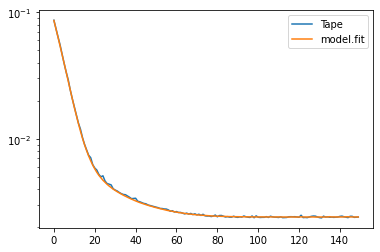

In [13]:
plt.plot(l1)
plt.plot(model.history.history['loss'])
plt.yscale('log')
plt.legend(['Tape', 'model.fit'])

Wonderful, the gradient tape and model.fit yield the identical results. Now we can only work on the penalized method.

### Gradient tape with monotonicity constraint
Here we override the training_step method and fit_model to include penalization term for the monotonicity constraint, i.e., soft parameter constraint. 
We transform our original problem
$$\min_{w\in \mathbb{R}^n} f(x)$$
$$s.t. g_i(x)\geq 0, for i\in\{0, \dots, k\} $$

to

$$\min_{w\in \mathbb{R}^n} f(x) + \mu \frac{1}{2}\sum_{i=0}^k \max\{-g_i(x), 0\}^2$$

where $g(x)$ corresponds to the first derivative of the spline basis features



In [14]:
def train_step(trainable_model, dset, penalization=False, epoch=0):  
    batch_loss = np.zeros(len(dset))
    batch_penal = np.zeros(len(dset))
    for i, (x_batch, y_batch) in enumerate(dset):
        watched_vars = trainable_model.trainable_variables
        with tf.GradientTape() as tape:
            tape.watch(watched_vars)
            if penalization:
                power = np.floor(epoch/5)
                coeff = np.minimum(10e4, 10*np.power(power, 2))
#                coeff = 1000
                # batch_penal[i] = 2 * 0.5 * np.sum(np.square(np.maximum(-np.matmul(transform_1d_der(x_batch[:,0].numpy()), trainable_model.trainable_variables[0].numpy()), 0)))
                penal =  coeff* 0.5 * tf.reduce_sum(tf.square(tf.math.maximum(-tf.matmul(transform_1d_der(x_batch[:,0]), watched_vars), 0)))
            else:
                penal = 0
            predictions = trainable_model(x_batch, training=True)
            loss_value = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_batch, predictions)) + penal
            batch_penal[i] = penal
            batch_loss[i] = loss_value.numpy()
        gradients = tape.gradient(loss_value, watched_vars)
        trainable_model.optimizer.apply_gradients(zip(gradients, watched_vars))
    return np.mean(batch_loss), np.mean(batch_penal)


def fit_model(trainable_model, x, y, epochs, penal=False, batch=32, verbose=False, shuffle=False, starting_epoch=0):
    losses = np.zeros(epochs)
    penalizations = np.zeros(epochs)
    y = y[:, None]
    if shuffle:
        #x, y = unison_shuffled_copies(x, y)
        dset = tf.data.Dataset.from_tensor_slices((x,y)).shuffle(len(y)).batch(batch)
    else:
        dset = tf.data.Dataset.from_tensor_slices((x,y)).batch(batch)
    for i in range(0, epochs):
        losses[i], penalizations[i] = train_step(trainable_model, dset=dset, penalization=penal, epoch=i + starting_epoch + 1)
        if verbose:
            print(f'Epoch:{i}/{epochs} Loss: {losses[i]}')
    return losses, penalizations

def MSME(input_x, trained_model):
    # Mean Square Monotonicity Error (MSME)
    return tf.reduce_sum(tf.square(tf.math.maximum(-tf.matmul(transform_1d_der(input_x), trained_model.trainable_variables), 0)))

In [15]:
# dset = tf.data.Dataset.from_tensor_slices((transform_1d(X_train), y_train)).batch(200)

In [16]:

# watched_vars = modelcp.trainable_variables
# for x_batch, y_batch in dset:
#     with tf.GradientTape() as tape:
#         tape.watch(watched_vars)
#         loss = 100 * 0.5 * tf.reduce_sum(tf.square(tf.math.maximum(-tf.matmul(transform_1d_der(x_batch[:,0]), watched_vars), 0)))
#     gradients = tape.gradient(loss, watched_vars) 
#     plt.plot(x_batch[:, 0], y_batch, 'o')

Separate into test/train datasets with ration 0.8

In [17]:
X_train, X_test, y_train, y_test, y_true_train, y_true_test = train_test_split(x, y_perturbed, y_true, train_size=0.2)

In [18]:
reset_weights(modelcp)
bs = 30
n_epochs = 3000

l1, s1 = fit_model(modelcp, transform_1d(X_train), y_train, epochs=n_epochs, verbose=False, batch=bs, shuffle=True, penal=False)
y_pred_0 = modelcp.predict_on_batch(transform_1d(x)).flatten()
l2, s2 = fit_model(modelcp, transform_1d(X_train), y_train, epochs=n_epochs, verbose=False, batch=bs, shuffle=True, penal=False)
y_pred_1 = modelcp.predict_on_batch(transform_1d(x)).flatten()
l3, s3 = fit_model(modelcp, transform_1d(X_train), y_train, epochs=n_epochs, verbose=False, batch=bs, shuffle=True, penal=False)
y_pred_2 = modelcp.predict_on_batch(transform_1d(x)).flatten()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[WARNING] [2021-07-04 18:33:00,836] [tensorflow] - AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x00000260688CF828> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object h

In [19]:
inputs_cpenal = tf.keras.Input(shape=(features,))
first_layer_cpenal = tf.keras.layers.Dense(1, activation='linear', use_bias=False)(inputs_cpenal[:, 1:])
modelcpenal = tf.keras.Model(inputs=inputs_cpenal, outputs=first_layer_cpenal, name="customp")
modelcpenal.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')
reset_weights(modelcpenal)

spenal_1, penal1 = fit_model(modelcpenal, transform_1d(X_train), y_train, epochs=n_epochs, penal=True, verbose=False, batch=bs, shuffle=True, starting_epoch=0)
y_pred_cp_0 = modelcpenal.predict_on_batch(transform_1d(x)).flatten()
spenal_2, penal2 = fit_model(modelcpenal, transform_1d(X_train), y_train, epochs=n_epochs, penal=True, verbose=False, batch=bs, shuffle=True, starting_epoch=n_epochs)
y_pred_cp_1 = modelcpenal.predict_on_batch(transform_1d(x)).flatten()
spenal_3, penal3 = fit_model(modelcpenal, transform_1d(X_train), y_train, epochs=n_epochs, penal=True, verbose=False, batch=bs, shuffle=True, starting_epoch=n_epochs * 2)
y_pred_cp_2 = modelcpenal.predict_on_batch(transform_1d(x)).flatten()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[WARNING] [2021-07-04 18:36:19,621] [tensorflow] - AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x00000260668FEDC8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object h

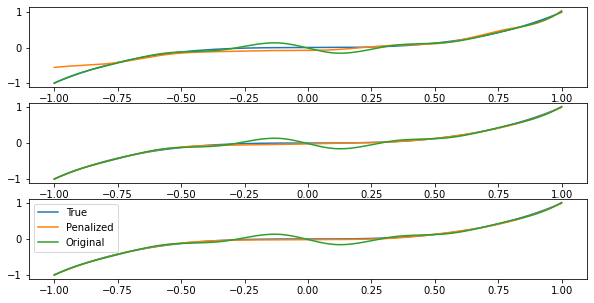

In [20]:
fig, ax = plt.subplots(nrows = 3, ncols=1, figsize=(10,5))
ax[0].plot(x, y_true)
ax[1].plot(x, y_true)
ax[2].plot(x, y_true)
ax[0].plot(x, y_pred_cp_0)
ax[1].plot(x, y_pred_cp_1)
ax[2].plot(x, y_pred_cp_2)
ax[0].plot(x, y_pred_0)
ax[1].plot(x, y_pred_1)
ax[2].plot(x, y_pred_2)
plt.legend(['True', 'Penalized', 'Original'])

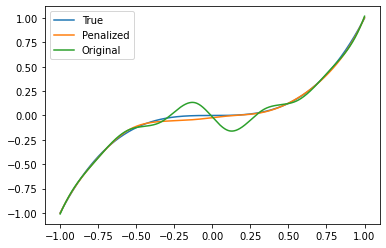

In [21]:
plt.plot(x, y_true)
plt.plot(x, y_pred_cp_1)
plt.plot(x, y_pred_1)
plt.legend(['True', 'Penalized', 'Original'])

Some stats about training accuracy:

In [22]:
print(f'MSE not penalized: {tf.keras.losses.mean_squared_error(y_true_test, tf.squeeze(modelcp(transform_1d(X_test))))}')
print(f'MSE penalized: {tf.keras.losses.mean_squared_error(y_true_test, tf.squeeze(modelcpenal(transform_1d(X_test))))}')
print(f'Mean squared monotonicity error not penalized: {MSME(X_test, modelcp)}')
print(f'Mean square monotonicity error penalized: {MSME(X_test, modelcpenal)}')

MSE not penalized: 0.00332758785225451
MSE penalized: 0.0001666569005465135
Mean squared monotonicity error not penalized: 147.49078369140625
Mean square monotonicity error penalized: 0.0


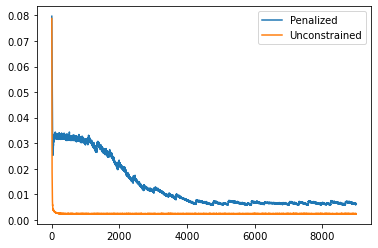

In [23]:
plt.plot(np.concatenate((spenal_1 - penal1, spenal_2 - penal2, spenal_3 - penal3)))
plt.plot(np.concatenate((l1, l2, l3)))
plt.legend(['Penalized', 'Unconstrained'])
#plt.yscale('log')

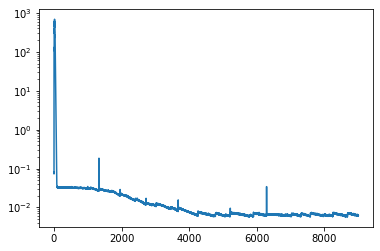

In [24]:
plt.plot(np.concatenate((spenal_1, spenal_2, spenal_3)))
plt.axhline(0, color='black', linestyle='--')
plt.yscale('log')

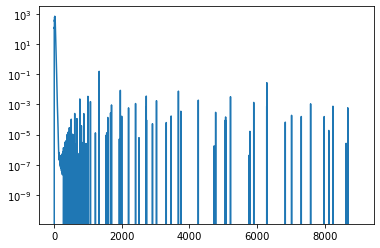

In [25]:
plt.plot(np.concatenate((penal1, penal2, penal3)))
plt.yscale('log')

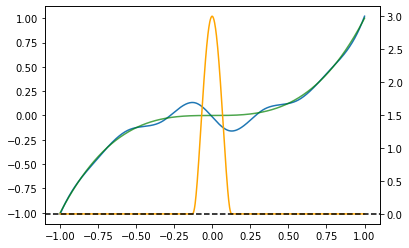

In [26]:
# reset_weights(modelcp)
fig, ax = plt.subplots()
ax.plot(x, modelcp(transform_1d(x)))
ax.plot(x, y_true,color='green', alpha=0.7)
ax1 = ax.twinx() 
ax1.plot(x, np.square(np.maximum(-np.matmul(transform_1d_der(x), modelcp.weights[0].numpy()), 0)), color='orange')
ax1.axhline(0, linestyle='--', color='black')

Eventhough this works we should find the optimal for the increasing penalty coefficient $\mu$

In [27]:
# def variable_penal(coeff):
#     def wrapped_constrained_penal(weights, x, i):
#         return coeff * 0.5 * np.mean(np.square(np.maximum(-np.matmul(transform_1d_der(x), weights), 0)))
#     return wrapped_constrained_penal

# coeffs = [0, 10, 100, 1000]
# preds = []
# losses = []
# penals = []
# batch = 30
# n_epochs = 100

# for coefficient in coeffs:
#     reset_weights(modelcpenal)
#     loss, penal = fit_model(modelcpenal, transform_1d(x), y_true, epochs=n_epochs, penal=variable_penal(coefficient), verbose=False, batch=bs, shuffle=True)
#     y_pred_cpenal = modelcpenal.predict_on_batch(transform_1d(x)).flatten()
#     penals.append(penal)
#     losses.append(loss)
#     preds.append(y_pred_cpenal)

# [plt.plot(x, preds[i]) for i, _ in enumerate(coeffs)]
# plt.plot(x, y_true)
# plt.legend(coeffs)

### Fitting 2-D function

In this section we fit the 2-D spline surface to greedy Q surface, using penalized and non penalized method.

In [28]:
p = Parameters()
aav= AAV(p)
w_points = 200
l_points = 100
ws = np.linspace(0, 200, w_points)
ls = np.linspace(0, 5, l_points)
ww, ll = np.meshgrid(ws, ls)
z = np.zeros_like(ww)
zt = np.zeros_like(ww)
coord = []
targets = []
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        z[j, i] = -aav.u(ly, wx)
        zt[j, i] = -aav.u(ly + 3, wx) - 15
        #features.append([ly, wx, z[j, i], zt[j, i]])
        coord.append([ly, wx])
        targets.append([z[j, i], zt[j, i]])
coord = np.array(coord, dtype='float32')
targets = np.array(targets, dtype='float32')

[INFO] [2021-07-04 18:39:37,876] [AAV] - Instantiated @ AAV


Text(0.5, 1.0, 'q(2)')

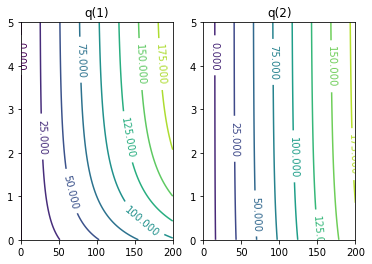

In [29]:
fig, ax = plt.subplots(ncols=2, nrows=1)
CS = ax[0].contour(ww, ll, z)
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('q(1)')
CS = ax[1].contour(ww, ll, zt)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].set_title('q(2)')

In [90]:
these_knots_w = np.linspace(0,200, 6, dtype='float32')
these_knots_l = np.linspace(0, 5, 3, dtype='float32')
these_knots_a = np.linspace(0, 1, 2, dtype='float32')
total_features = (len(these_knots_w)+2) * (len(these_knots_l)+2)

from itertools import product

def transform_1d_w(eval_point):
    numpyknots = np.concatenate(([0,0,0],these_knots_w,[200, 200, 200]))
    y_py = np.zeros((eval_point.shape[0], len(these_knots_w)+ 2 + 1), dtype='float32')
    y_py[:, 0] = eval_point
    for i in range(len(these_knots_w) + 2):
        y_py[:,i+1] = BSpline.construct_fast(numpyknots, (np.arange(len(these_knots_w)+2)==i).astype(float), 3, extrapolate=False)(eval_point)
    return y_py

def transform_1d_l(eval_point):
    numpyknots = np.concatenate(([0,0,0],these_knots_l,[5, 5, 5]))
    y_py = np.zeros((eval_point.shape[0], len(these_knots_l) + 2 + 1), dtype='float32')
    y_py[:, 0] = eval_point
    for i in range(len(these_knots_l)+2):
        y_py[:,i+1] = BSpline.construct_fast(numpyknots, (np.arange(len(these_knots_l)+2)==i).astype(float), 3, extrapolate=False)(eval_point)
    return y_py

def transform_1d_a(eval_point):
    numpyknots = np.concatenate(([0],these_knots_a,[1]))
    y_py = np.zeros((eval_point.shape[0], len(these_knots_a)  + 1), dtype='float32')
    y_py[:, 0] = eval_point
    for i in range(len(these_knots_a)):
        y_py[:,i+1] = BSpline.construct_fast(numpyknots, (np.arange(len(these_knots_a))==i).astype(float), 1, extrapolate=False)(eval_point)
    return y_py

def transform_2d(xy_inp):
    w_features = transform_1d_w(xy_inp[:, 1])
    l_features = transform_1d_l(xy_inp[:, 0])
    final = np.zeros((len(xy_inp), total_features + 2))
    final[:, 0] = l_features[:, 0]
    final[:, 1] = w_features[:, 0]
    for i, row in enumerate(w_features):
        final[i, 2:] = [i * j for i, j in product(row[1:], l_features[i, 1:])]
    return final

def transform_2d_w_a(xy_inp):
    # same transform but with A in the architecture
    w_features = transform_1d_w(xy_inp[:, 1])
    l_features = transform_1d_l(xy_inp[:, 0])
    final = np.zeros((len(xy_inp), total_features + 2))
    final[:, 0] = l_features[:, 0]
    final[:, 1] = w_features[:, 0]
    for i, row in enumerate(w_features):
        final[i, 2:] = [i * j for i, j in product(row[1:], l_features[i, 1:])]
    return final

def transform_1d_w_der(eval_point):
    numpyknots = np.concatenate(([0,0,0], these_knots_w, [200, 200, 200]))
    y_first = np.zeros((eval_point.shape[0], len(these_knots_w) + 2), dtype='float32')
    y_second = np.zeros_like(y_first)
    for i in range(len(these_knots_w) + 2):
        y_first[:,i] = BSpline.construct_fast(numpyknots, (np.arange(len(these_knots_w)+2)==i).astype(float), 3, extrapolate=False).derivative()(eval_point)
        y_second[:,i] = BSpline.construct_fast(numpyknots, (np.arange(len(these_knots_w)+2)==i).astype(float), 3, extrapolate=False).derivative().derivative()(eval_point)
    return y_first, y_second
        
def transform_1d_l_der(eval_point):
    numpyknots = np.concatenate(([0,0,0],these_knots_l,[5, 5, 5]))
    y_first = np.zeros((eval_point.shape[0], len(these_knots_l) + 2 ), dtype='float32')
    y_second = np.zeros_like(y_first)
    for i in range(len(these_knots_l)+2):
        y_first[:,i] = BSpline.construct_fast(numpyknots, (np.arange(len(these_knots_l)+2)==i).astype(float), 3, extrapolate=False).derivative()(eval_point)
        y_second[:,i] = BSpline.construct_fast(numpyknots, (np.arange(len(these_knots_l)+2)==i).astype(float), 3, extrapolate=False).derivative().derivative()(eval_point)
    return y_first, y_second

def D(xy_inp):
    w_features = transform_1d_w(xy_inp[:, 1])
    l_features = transform_1d_l(xy_inp[:, 0])
    w_features_der, w_features_der2 = transform_1d_w_der(xy_inp[:, 1])
    l_features_der, l_features_der2 = transform_1d_l_der(xy_inp[:, 0])
    first_der_features = total_features
    first_w = np.zeros((len(xy_inp), first_der_features), dtype='float32')
    first_l = np.zeros_like(first_w)
#     final[:, 0] = l_features[:, 0]
#     final[:, 1] = w_features[:, 1]
    for i, row in enumerate(w_features):
        first_w[i, :] = [i * j for i, j in product(w_features_der[i, :], l_features[i, 1:])]
        first_l[i, :] = [i * j for i, j in product(w_features[i, 1:], l_features_der[i, :])]
    return first_w, first_l, 0, 0

In [91]:
these_knots_a

array([0., 1.], dtype=float32)

In [92]:
transform_2d(np.array([[0.5, 150.]]))

array([[5.00000000e-01, 1.50000000e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.33333344e-03, 1.13020837e-03, 1.35416674e-04,
        5.20833373e-06, 0.00000000e+00, 1.61333337e-01, 1.36755198e-01,
        1.63854156e-02, 6.30208349e-04, 0.00000000e+00, 2.95333356e-01,
        2.50341147e-01, 2.99947932e-02, 1.15364592e-03, 0.00000000e+00,
        5.40000014e-02, 4.57734354e-02, 5.48437517e-03, 2.10937505e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [98]:
transform_1d_a(np.array([0., 1.]))

array([[0., 1., 0.],
       [1., 0., 1.]], dtype=float32)

In [31]:
features = transform_2d(coord)

In [32]:
X2d_train, X2d_test, y2d_train, y2d_test = train_test_split(features, targets, train_size=0.2)

In [33]:
inputs = tf.keras.Input(shape=(total_features + 2,))
first_layer = tf.keras.layers.Dense(2, activation='linear', use_bias=False)(inputs[:, 2:])
model = tf.keras.Model(inputs=inputs, outputs=first_layer, name="combined")
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')

In [34]:
model.fit(X2d_train, y2d_train, epochs = 10000, verbose=False, batch_size=256)
model.fit(X2d_train, y2d_train, epochs = 1, batch_size=256)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[WARNING] [2021-07-04 18:39:39,497] [tensorflow] - AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000026069CB0CA8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has n

In [35]:
preds = model.predict_on_batch(X2d_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[WARNING] [2021-07-04 18:40:43,247] [tensorflow] - AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x0000026069BA0318> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object h

In [36]:
def plot_3d(x, y, z):
    z1 = z[:, 0]
    z2 = z[:, 1]
    grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
    grid_z1 = griddata((x, y), z1, (grid_x, grid_y), method='cubic')
    grid_z2 = griddata((x, y), z2, (grid_x, grid_y), method='cubic')
    fig, ax = plt.subplots(ncols=2, nrows=1)
    CS = ax[0].contour(grid_x, grid_y, grid_z1)
    ax[0].clabel(CS, inline=1, fontsize=10)
    ax[0].set_title('spline q(1)')
    CS = ax[1].contour(grid_x, grid_y, grid_z2)
    ax[1].clabel(CS, inline=1, fontsize=10)
    ax[1].set_title('spline q(1)')
    
def MSME2d(input_x, trained_model):
    # Mean Square Monotonicity Error (MSME)
    first_l, first_w , second_l, second_w = D(X2d_test)
    return tf.reduce_sum(tf.square(tf.math.maximum(-tf.matmul(first_l, trained_model.trainable_variables), 0))) + \
            tf.reduce_sum(tf.square(tf.math.maximum(-tf.matmul(first_w, trained_model.trainable_variables), 0)))

MSE: 48.04673767089844
MSME: 22261.7109375


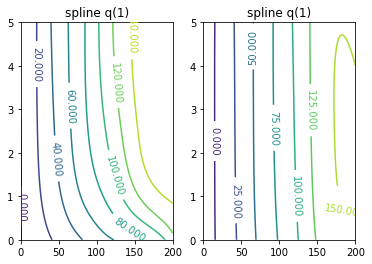

In [37]:
plot_3d(X2d_test[:, 1], X2d_test[:, 0], preds)
print(f'MSE: {tf.reduce_mean(tf.keras.losses.mean_squared_error(y2d_test, preds))}')
print(f'MSME: { MSME2d(X2d_test, model)}')

In [38]:
def train_step_2d(trainable_model, dset, batch=32, epoch=0, penalization=False):
    batch_loss = np.zeros(len(dset))
    batch_penal = np.zeros(len(dset))
    for i, (x_batch, y_batch) in enumerate(dset):
        watched_vars = trainable_model.trainable_variables
        with tf.GradientTape() as tape:
            tape.watch(watched_vars)
            if penalization:
                first_l, first_w, second_w, second_l = D(x_batch)
                power = np.floor(epoch/10)
                coeff = np.minimum(10e8, 10*np.power(power, 2))
                penal =  coeff* 0.5 * (tf.reduce_sum(tf.square(tf.math.maximum(-tf.matmul(first_l, watched_vars), 0))) + 
                                      tf.reduce_sum(tf.square(tf.math.maximum(-tf.matmul(first_w, watched_vars), 0))))
            else:
                penal = 0
            predictions = trainable_model(x_batch, training=True)
            loss_value = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_batch, predictions)) + penal
            batch_penal[i] = penal
            batch_loss[i] = loss_value.numpy()
        gradients = tape.gradient(loss_value, watched_vars)
        trainable_model.optimizer.apply_gradients(zip(gradients, watched_vars))
    return np.mean(batch_loss), np.mean(batch_penal)


def fit_model_2d(trainable_model, X, y, epochs, verbose=False, batch=32, shuffle=False, starting_epoch=0, penal=False):
    losses = np.zeros(epochs)
    penalizations = np.zeros(epochs)
    if shuffle:
        dset = tf.data.Dataset.from_tensor_slices((X,y)).shuffle(len(y)).batch(batch)
    else:
        dset = tf.data.Dataset.from_tensor_slices((X,y)).batch(batch)
    for i in range(0, epochs):
        losses[i], penalizations[i] = train_step_2d(trainable_model, dset=dset, penalization=penal, epoch= i + starting_epoch + 1)
        if verbose:
            print(f'Epoch:{i}/{epochs} Loss: {losses[i]}')
    return losses, penalizations

In [39]:
inputs_penal_2d = tf.keras.Input(shape=(total_features+2,))
first_layer_penal_2d = tf.keras.layers.Dense(2, activation='linear', use_bias=False)(inputs_penal_2d[:, 2:])
modelp2d = tf.keras.Model(inputs=inputs_penal_2d, outputs=first_layer_penal_2d, name="combined")
modelp2d.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')

starting_2d_weights = modelp2d.get_weights().copy()

def reset_weights_2d(resetting_model, weights):
    resetting_model.set_weights(weights)


In [40]:
n_epochs = 10000
batch_size = 32

losses2d, penals2d = fit_model_2d(modelp2d, X2d_train, y2d_train, epochs=n_epochs, verbose=False, batch=batch_size, shuffle=True, starting_epoch=0, penal=False)

In [41]:
preds2d = modelp2d(X2d_test)

MSE: 0.008568841964006424
MSME: 0.050743088126182556


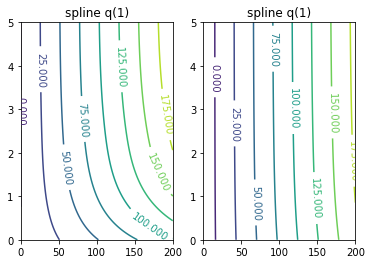

In [42]:
plot_3d(X2d_test[:, 1], X2d_test[:, 0], preds2d)
print(f'MSE: {tf.reduce_mean(tf.keras.losses.mean_squared_error(y2d_test, preds2d))}')
print(f'MSME: { MSME2d(X2d_test, modelp2d)}')

In [43]:
inputs_penal_2d_penalized = tf.keras.Input(shape=(total_features+2,))
first_layer_penal_2d_penalized = tf.keras.layers.Dense(2, activation='linear', use_bias=False)(inputs_penal_2d_penalized[:, 2:])
modelp2d_penalized = tf.keras.Model(inputs=inputs_penal_2d_penalized, outputs=first_layer_penal_2d_penalized, name="combined")
modelp2d_penalized.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')

# initialize to the same starting state
reset_weights_2d(modelp2d_penalized, starting_2d_weights)

losses2dpenalized, penals2dpenalized = fit_model_2d(modelp2d_penalized, np.float32(X2d_train), np.float32(y2d_train), epochs=n_epochs, verbose=False, batch=batch_size, shuffle=True, starting_epoch=0, penal=True)

KeyboardInterrupt: 

In [ ]:
preds2d_penal = modelp2d_penalized(X2d_test)

In [ ]:
plot_3d(X2d_test[:, 1], X2d_test[:, 0], preds2d_penal)
print(f'MSE: {tf.reduce_mean(tf.keras.losses.mean_squared_error(y2d_test, preds2d_penal))}')
print(f'MSME: { MSME2d(X2d_test, modelp2d_penalized)}')

In [ ]:
plt.plot(losses2dpenalized)
plt.plot(losses2d)
# plt.plot(modelc)

In [ ]:
plt.plot(penals2dpenalized)

# plt.plot(modelc)

In [ ]:
plt.plot(X2d_train[:, 1], X2d_train[:, 0], 'x')

In [ ]:
tf.reduce_sum(tf.matmul(D(X2d_test)[0], modelp2d_penalized.weights))

In [ ]:
tf.matmul(D(X2d_test)[0], modelp2d_penalized.weights)

In [ ]:

def MSME2d(input_x, trained_model):
    # Mean Square Monotonicity Error (MSME)
    first_l, first_w , second_l, second_w = D(X2d_test)
    return tf.reduce_sum(tf.square(tf.math.maximum(-tf.matmul(first_l, trained_model.trainable_variables), 0))) + \
            tf.reduce_sum(tf.square(tf.math.maximum(-tf.matmul(first_w, trained_model.trainable_variables), 0)))

In [ ]:
MSME2d(X2d_test, modelp2d_penalized)

In [ ]:
MSME2d(X2d_test, modelp2d)

In [ ]:
transform_1d_w(testtest).dtype

In [ ]:
def reset_weights_2d(resetting_model, weights):
    resetting_model.set_weights(weights)

In [ ]:
 np.float32(X2d_train)

In [ ]:
these_knots.dtype